In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import nibabel as nib
import scipy.io
import time
import pandas as pd
import glob
import re
import os

from joblib import Parallel, delayed
from tqdm import tqdm
from itertools import product

In [6]:
def ReadModeFiles(index,list_file):
        NbM = len(list_file)
        temp_modes = [None] * NbM  # empty list of size NbM 
        for i, filename in enumerate(list_file):
            metabo_mode = pd.read_csv(filename, header=None, skiprows=[0]).values
            m = re.search("[0-9]T_.{1,6}_Exact", filename)
            name = bytes(filename[m.span()[0]+3:m.span()[1]-6].strip(), 'utf8')
            temp_modes[index[name]] = metabo_mode
        return temp_modes

In [2]:
list_file = glob.glob('../MetabModes/7T_TE0/*Exact_Modes.txt')

In [5]:
list_file[0]

'../MetabModes/7T_TE0/Ideal_FID_TE0_T12_0_7T_Act_Exact_Modes.txt'

In [21]:
version='v4'
path = '/workspace/walinet/PaulTrainData/'


#subjects = ['/3DMRSIMAP_Vol_04_A_1_2024-09-06_L2_0p0005', '3DMRSIMAP_Vol_08_A_1_2024-09-07_L2_0p0005'] #'3DMRSIMAP_Vol_10_A_1_2024-09-04_L2_0p0005','3DMRSIMAP_Vol_16_A_1_2024-09-05_L2_0p0005'
subjects = ['3DMRSIMAP_Vol_04_A_1_2024-09-06_L2_0p0005',
            '3DMRSIMAP_Vol_05_A_1_2024-09-02_L2_0p0005',
            '3DMRSIMAP_Vol_06_A_1_2024-08-22_L2_0p0005',
            '3DMRSIMAP_Vol_08_A_1_2024-09-07_L2_0p0005',
            '3DMRSIMAP_Vol_09_A_1_2024-09-03_L2_0p0005']

# Water Removal
b_RemWat = True
WatSuppComp = 32 # Number of component for the HSVD water removal (advised: 16 at 3T and 32 at 7T)
minFreq = -150 # -150Hz(7T) # +-0.5ppm
maxFreq = 150 # 150
parallel_jobs = 20

bandwidth = 3000 # 3khz
dwell_time = 1/bandwidth

# Simulation
nSpectra=100#0#00
nRandomLipid=20
MaxLipidScaling=80

MaxSNR=10
MinSNR=1

N=960
NMRFreq= 297189866.0 #127.7 *10**6 #297189866.0 #
sampling_rate = 1/dwell_time  # Hz  sampling_rate = 1/dwell_time

MaxAcquDelay=0.002
MaxFreq_Shift = 40
#MinPeak_Width=4
#MaxPeak_Width=20
MinPeak_Width=20
MaxPeak_Width=100

#for sub in subjects:
sub = subjects[0]
p_data = path + sub + '/TESTING_beforeLipid.mat'
p_wat = path + sub + '/WaterReference.mat'
p_save = path + sub + '/'

#####################
##### Load Data #####
#####################

fh = h5py.File(p_data,'r')

In [22]:
#################################
##### Metabolite Simulation #####
#################################

# Calculate the time vector
t = np.arange(N) / sampling_rate

# Simulation parameters
AcquDelay = (np.random.rand(nSpectra, 1)-0.5)*2 * MaxAcquDelay

PhShift=np.random.rand(nSpectra, 1) * 2 * np.pi
TimeSerieClean = np.zeros(( N), dtype=np.complex64)

FreqShift = (np.random.rand(nSpectra, 1)*2 - 1) * MaxFreq_Shift

PeakWidth = MinPeak_Width + np.random.rand(nSpectra, 1) * (MaxPeak_Width - MinPeak_Width)
ponder_peaks = np.random.rand(nSpectra, 1)
PeakWidth_Gau = np.multiply(ponder_peaks, PeakWidth)
PeakWidth_Lor = np.multiply(1-ponder_peaks, PeakWidth)

SNR = MinSNR + np.random.rand(nSpectra, 1) * (MaxSNR - MinSNR)



########################################
#### Perpare metabolite information ####
########################################
def ReadModeFiles(index,list_file):
    NbM = len(list_file)
    temp_modes = [None] * NbM  # empty list of size NbM 
    for i, filename in enumerate(list_file):
        metabo_mode = pd.read_csv(filename, header=None, skiprows=[0]).values
        m = re.search("[0-9]T_.{1,6}_Exact", filename)
        name = bytes(filename[m.span()[0]+3:m.span()[1]-6].strip(), 'utf8')
        temp_modes[index[name]] = metabo_mode
    return temp_modes

index = {}  # mapping of metabolite name to index
mean_std_csv = pd.read_csv('/workspace/walinet/MetabModes/Metab_Mean_STD.txt', header=None).values

for i, v in enumerate(mean_std_csv[:, 0].astype(str)):
    index[ bytes(v.strip(), 'utf8') ] = i

mean_std = mean_std_csv[:, 1:].astype(np.float32)

list_file = glob.glob('/workspace/walinet/MetabModes/7T_TE0/*Exact_Modes.txt')
NbM = len(list_file)
metabo_modes = [[[None] for j in range(NbM)] for i in range(6)]
temp_modes = ReadModeFiles(index,list_file)
metabo_modes[0]=temp_modes

# Metabolic parameters
TempMetabData = np.zeros( (len(metabo_modes[0]), N), dtype=np.complex64)
BasisI = 0#np.floor(np.random.rand(nSpectra, 1) * 6)

Amplitude = mean_std[:, 1]* np.random.randn(nSpectra, NbM) + mean_std[:, 0]
Amplitude = Amplitude.clip(min=0)


#############################
#### Simulate metabolite ####
#############################
MetabSpectrum = np.zeros((nSpectra, N), dtype=np.complex128)
for n in tqdm(range(nSpectra)):

    TempMetabData =0*TempMetabData
    for f, mode in enumerate(metabo_modes[0]):   # metabo_modes[int(BasisI[n])]
            Freq = ((4.7-mode[:, 0]) * 1e-6 * NMRFreq)[...,None]

            for Nuc in range(len(Freq)):
                if (mode[Nuc, 0] > 0.0) & (mode[Nuc, 0] < 4.5)  : # only for the window of interest 
                    TempMetabData[f, :] += mode[Nuc, 1][...,None] * np.exp(1j * mode[Nuc, 2][...,None]) * np.exp(2 * np.pi * 1j * (t + AcquDelay[n])  * (Freq[Nuc]))

    TimeSerieClean=0*TimeSerieClean
    for f, _ in enumerate(metabo_modes[0]):  # metabo_modes[int(BasisI[ex])]
        TimeSerieClean[:] += Amplitude[n, f] * TempMetabData[f, :]* np.exp(1j * PhShift[n])  

    TimeSerieClean[:] *= np.exp( (t* 1j * 2 * np.pi * FreqShift[n] ) + (- (np.square(t)) * (np.square(PeakWidth_Gau[n]))) + ((np.absolute(t)) * (- PeakWidth_Lor[n]) ) )
    SpectrumTemp = np.fft.fftshift(np.fft.fft(TimeSerieClean[:],axis=0))

    # SNR
    NCRand=(np.random.randn(N) + 1j * np.random.randn(N))
    TimeSerie = TimeSerieClean + np.fft.ifft(SpectrumTemp.std()/0.65 / SNR[n] * NCRand,axis=0)

    MetabSpectrum[n] = np.fft.fftshift(np.fft.fft(TimeSerie))

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.18it/s]


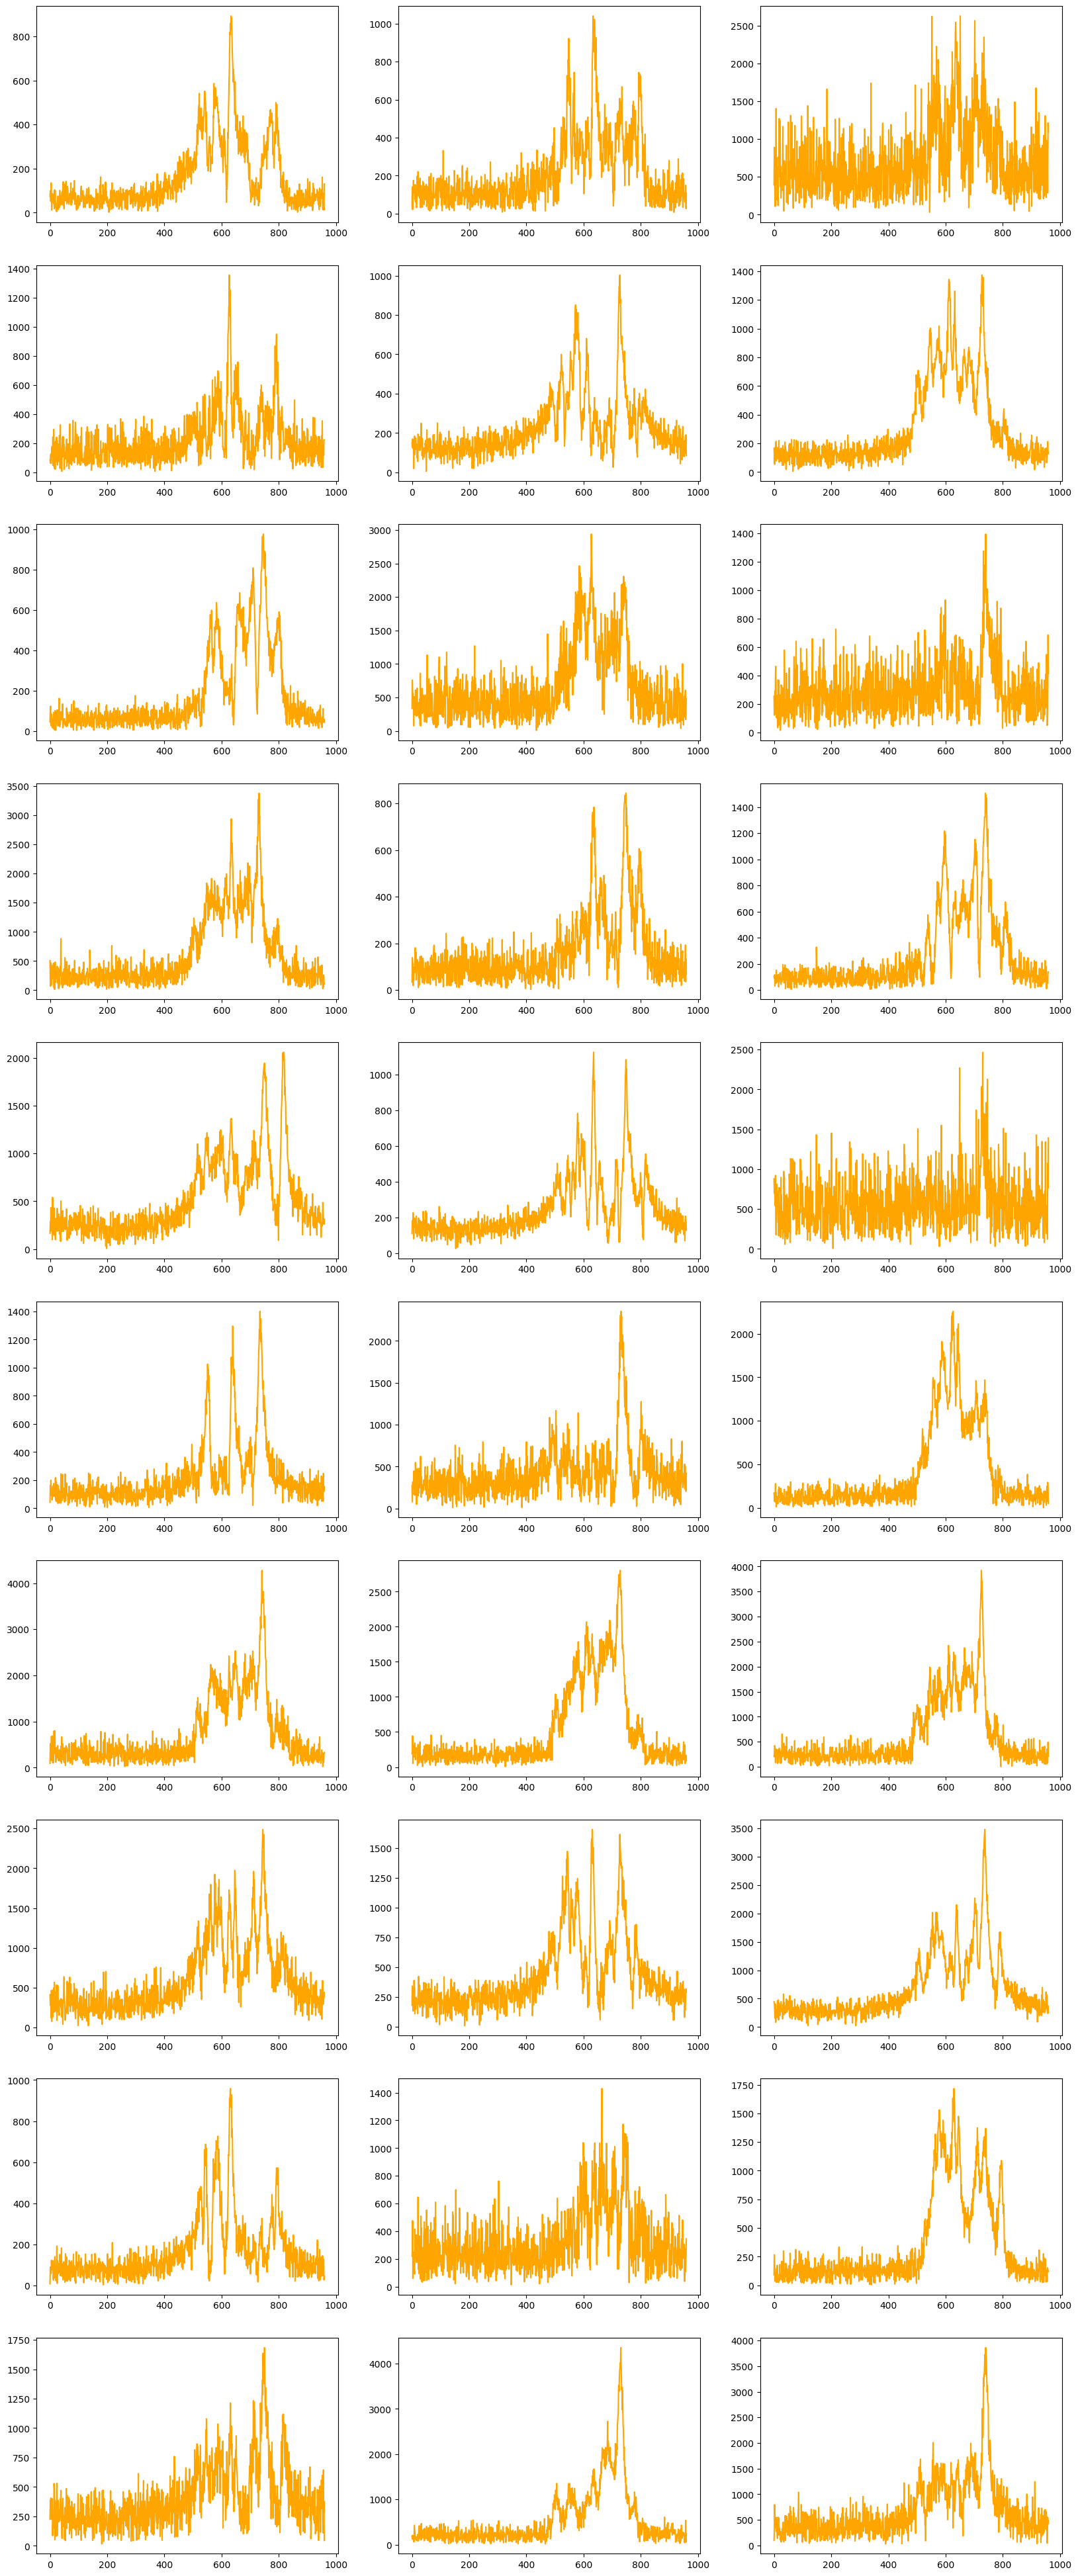

In [23]:
fig, ax = plt.subplots(nrows=10, ncols=3, figsize=(20,50), sharey=False)
for i in range(10):
    for ii in range(3):
        sl = i*3 + ii

        ax[i,ii].plot(np.abs(MetabSpectrum[sl]), label='pred', color='orange')
        #ax[i,ii].plot(np.abs(np.fft.ifft(np.fft.ifftshift(MetabSpectrum[sl]))), label='pred', color='orange')
        #ax[i,ii].plot(np.abs(lipid_proj[i]), label='pred', color='blue')
        #ax[i,ii].set_ylim([0,3*10**11])
        #ax[i,ii].legend()
        #ax[i,ii].title.set_text('index: ' + str(sl))
fig.patch.set_facecolor('white')
fig.patch.set_alpha(1)
#plt.savefig("images/Subject"+sub+"_"+exp+"_lipidrem")
plt.show()